In [ ]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1bb4f3aca09d2d1a1729b3e51b9599050b01a63fc6db2f4f2658939b54c8d939
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Venmo Transaction Analysis") \
    .getOrCreate()


### Text Analysis
#### Question 2

In [ ]:
from pyspark.sql import SparkSession
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("Venmo Transaction Analysis").getOrCreate()

# Load the Parquet file using pandas to ensure compatibility
try:
    sample_df = spark.read.parquet("VenmoSample.snappy.parquet")
except Exception as e:
    print(f"Failed to load Parquet file: {e}")
    # Try loading as a pandas DataFrame and then convert
    sample_df_pd = pd.read_parquet("VenmoSample.snappy.parquet")
    sample_df = spark.createDataFrame(sample_df_pd)

# Load the dictionaries
text_dict_pd = pd.read_excel("Venmo Word Classification Dictonary BAX-423 (1).xlsx")
emoji_dict_pd = pd.read_csv("Venmo_Emoji_Classification_Dictionary.csv")

# Convert pandas DataFrame to Spark DataFrame
text_dict = spark.createDataFrame(text_dict_pd)
emoji_dict = spark.createDataFrame(emoji_dict_pd)

# Display data to ensure it's loaded correctly
sample_df.show(5)
text_dict.show(5)
emoji_dict.show(5)


+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af2...|
|2960727|3442373|         payment|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
only showing top 5 rows

+----------+---------+---------+--------+------+--------------+----

In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import col, udf, array, array_contains, lit
from pyspark.sql.types import ArrayType, StringType

# Initialize Spark session
spark = SparkSession.builder.appName("Venmo Transaction Analysis").getOrCreate()

# Load the sample data
sample_df = spark.read.parquet("VenmoSample.snappy.parquet")

# Load the dictionaries
text_dict_pd = pd.read_excel("Venmo Word Classification Dictonary BAX-423 (1).xlsx")
emoji_dict_pd = pd.read_csv("Venmo_Emoji_Classification_Dictionary.csv")

# Convert pandas DataFrame to Spark DataFrame
text_dict = spark.createDataFrame(text_dict_pd)
emoji_dict = spark.createDataFrame(emoji_dict_pd)

# Display the data to verify columns
sample_df.show(5)
text_dict.show(5)
emoji_dict.show(5)

# Extract words and categories from text dictionary
text_dict_broadcast = {}
for column in text_dict.columns:
    words = text_dict.select(column).rdd.flatMap(lambda x: x).collect()
    for word in words:
        if isinstance(word, str) and word.strip():
            text_dict_broadcast[word.strip().lower()] = column

# Extract emojis and categories from emoji dictionary
emoji_dict_broadcast = {}
for column in emoji_dict.columns:
    emojis = emoji_dict.select(column).rdd.flatMap(lambda x: x).collect()
    for emoji in emojis:
        if isinstance(emoji, str) and emoji.strip():
            emoji_dict_broadcast[emoji.strip()] = column

# UDF to classify text messages
def classify_text(message):
    words = message.split()
    categories = [text_dict_broadcast.get(word.lower()) for word in words if text_dict_broadcast.get(word.lower())]
    return categories

# UDF to classify emoji messages
def classify_emoji(message):
    emojis = [char for char in message if char in emoji_dict_broadcast]
    categories = [emoji_dict_broadcast[char] for char in emojis]
    return categories

classify_text_udf = udf(lambda msg: classify_text(msg), ArrayType(StringType()))
classify_emoji_udf = udf(lambda msg: classify_emoji(msg), ArrayType(StringType()))

# Apply the UDFs to classify messages
classified_df = sample_df.withColumn("TextCategories", classify_text_udf(col("description"))) \
                         .withColumn("EmojiCategories", classify_emoji_udf(col("description")))

classified_df.show(truncate=False)

# Calculate the percentage of emoji-only transactions
emoji_only_df = classified_df.filter((col("TextCategories").isNull() | (col("TextCategories") == array().cast("array<string>"))) & (col("EmojiCategories").isNotNull()))
total_transactions = classified_df.count()
emoji_only_transactions = emoji_only_df.count()
emoji_only_percentage = (emoji_only_transactions / total_transactions) * 100

print(f"Percentage of emoji-only transactions: {emoji_only_percentage:.2f}%")


+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af2...|
|2960727|3442373|         payment|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
only showing top 5 rows

+----------+---------+---------+--------+------+--------------+----

In [ ]:
from pyspark.sql.functions import explode, desc

# Explode the EmojiCategories column to get individual emojis
exploded_emojis_df = classified_df.withColumn("Emoji", explode(col("EmojiCategories")))

# Count the occurrences of each emoji
emoji_counts_df = exploded_emojis_df.groupBy("Emoji").count().orderBy(desc("count"))

# Show the top 5 most popular emojis
top_5_emojis = emoji_counts_df.limit(5)
top_5_emojis.show()

# Explode the EmojiCategories column to get individual categories
exploded_categories_df = classified_df.withColumn("EmojiCategory", explode(col("EmojiCategories")))

# Count the occurrences of each emoji category
category_counts_df = exploded_categories_df.groupBy("EmojiCategory").count().orderBy(desc("count"))

# Show the top 3 most popular emoji categories
top_3_categories = category_counts_df.limit(3)
top_3_categories.show()


+--------------+-------+
|         Emoji|  count|
+--------------+-------+
|          Food|1744390|
|        People|1011889|
|       Utility| 434942|
|      Activity| 423988|
|Transportation| 258830|
+--------------+-------+

+-------------+-------+
|EmojiCategory|  count|
+-------------+-------+
|         Food|1744390|
|       People|1011889|
|      Utility| 434942|
+-------------+-------+



#### Question 3

In [ ]:
from pyspark.sql.functions import explode, concat_ws, col, lit, count

# Explode TextCategories and EmojiCategories to get individual categories
exploded_text_df = classified_df.withColumn("Category", explode(col("TextCategories")))
exploded_emoji_df = classified_df.withColumn("Category", explode(col("EmojiCategories")))

# Combine the exploded DataFrames
combined_df = exploded_text_df.union(exploded_emoji_df)

# Group by user and category to count the number of transactions per category for each user
user_category_counts_df = combined_df.groupBy("user1", "Category").agg(count("*").alias("CategoryCount"))

# Calculate the total number of transactions for each user
total_transactions_df = combined_df.groupBy("user1").agg(count("*").alias("TotalTransactions"))

# Join the category counts with the total transactions
user_profile_df = user_category_counts_df.join(total_transactions_df, on="user1")

# Calculate the percentage of transactions in each category for each user
user_profile_df = user_profile_df.withColumn("Percentage", (col("CategoryCount") / col("TotalTransactions")) * 100)

# Display the spending behavior profile for each user
user_profile_df.show(truncate=False)


+-----+---------------+-------------+-----------------+------------------+
|user1|Category       |CategoryCount|TotalTransactions|Percentage        |
+-----+---------------+-------------+-----------------+------------------+
|3    |People         |1            |3                |33.33333333333333 |
|3    |Utility        |1            |3                |33.33333333333333 |
|3    |Food           |1            |3                |33.33333333333333 |
|12   |Cash           |3            |9                |33.33333333333333 |
|12   |Utility        |2            |9                |22.22222222222222 |
|12   |Activity       |2            |9                |22.22222222222222 |
|12   |Event          |1            |9                |11.11111111111111 |
|12   |Food           |1            |9                |11.11111111111111 |
|13   |Transportation |3            |36               |8.333333333333332 |
|13   |Event          |3            |36               |8.333333333333332 |
|13   |Cash           |1 

#### Question 4

    MonthInterval         Category     Average  StandardDeviation
0               0           People   88.095238          20.892772
1               0          Utility   93.750000          12.500000
2               9   Transportation   50.000000                NaN
3               3          Utility   76.666667          32.489314
4               4          Utility  100.000000                NaN
5               3             Food   50.000000                NaN
6               5         Activity   50.000000                NaN
7               5           People  100.000000                NaN
8               6             Food  100.000000                NaN
9              15             Food  100.000000                NaN
10             19           People  100.000000                NaN
11              0            Event   75.000000          35.355339
12             11           People   50.000000                NaN
13             10           People   75.000000          35.355339
14        

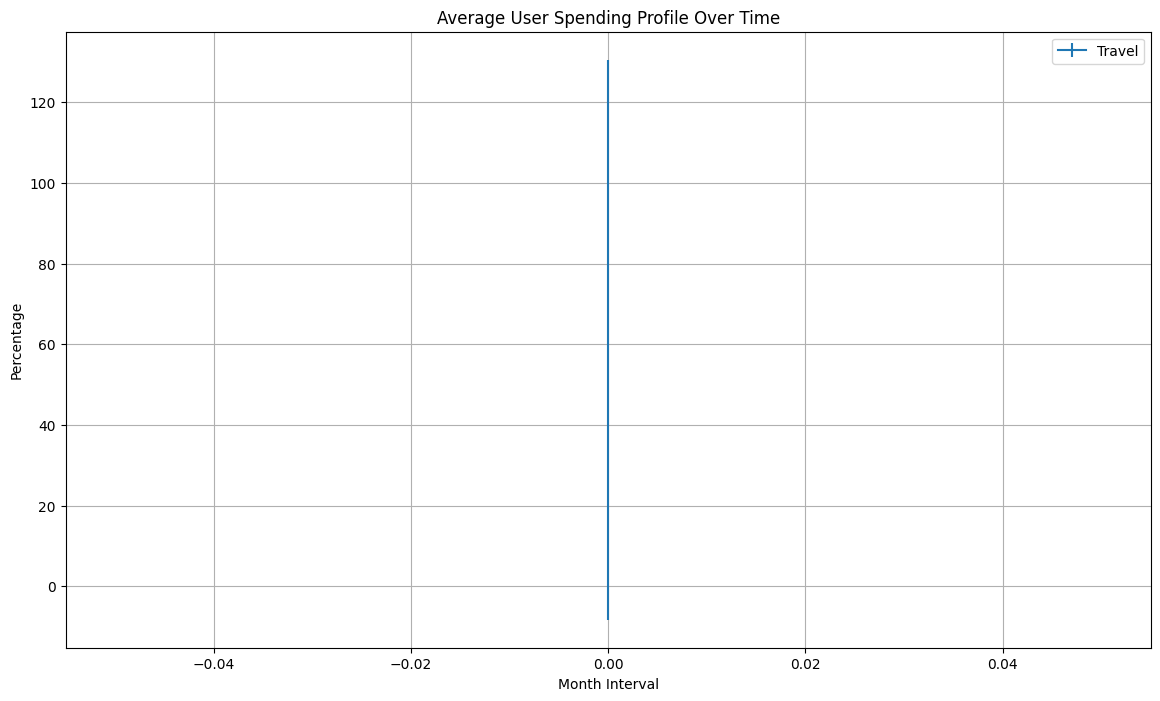

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import col, min, months_between, floor, count, avg, stddev, explode
import pandas as pd
import matplotlib.pyplot as plt

# Ensure unique names after join
classified_df = classified_df.withColumnRenamed("MonthInterval", "classified_MonthInterval")
sample_df = sample_df.withColumnRenamed("MonthInterval", "sample_MonthInterval")

# Join classified_df with sample_df to get MonthInterval
classified_df = classified_df.join(sample_df.select("user1", "datetime", "sample_MonthInterval"), on=["user1", "datetime"])

# Rename sample_MonthInterval back to MonthInterval after join
classified_df = classified_df.withColumnRenamed("sample_MonthInterval", "MonthInterval")

# Explode TextCategories and EmojiCategories to get individual categories
exploded_text_df = classified_df.withColumn("Category", explode(col("TextCategories")))
exploded_emoji_df = classified_df.withColumn("Category", explode(col("EmojiCategories")))

# Combine the exploded DataFrames
combined_df = exploded_text_df.union(exploded_emoji_df)

# Group by user, month interval, and category to count the number of transactions per category for each user
user_monthly_category_counts_df = combined_df.groupBy("user1", "MonthInterval", "Category").agg(count("*").alias("CategoryCount"))

# Calculate the total number of transactions for each user at each month interval
total_monthly_transactions_df = combined_df.groupBy("user1", "MonthInterval").agg(count("*").alias("TotalTransactions"))

# Join the category counts with the total transactions
user_monthly_profile_df = user_monthly_category_counts_df.join(total_monthly_transactions_df, on=["user1", "MonthInterval"])

# Calculate the percentage of transactions in each category for each user at each month interval
user_monthly_profile_df = user_monthly_profile_df.withColumn("Percentage", (col("CategoryCount") / col("TotalTransactions")) * 100)

# Aggregate to compute the average and standard deviation for each category at each month interval
avg_stddev_profile_df = user_monthly_profile_df.groupBy("MonthInterval", "Category").agg(
    avg("Percentage").alias("Average"),
    stddev("Percentage").alias("StandardDeviation")
)

# Collect the results to plot
results = avg_stddev_profile_df.collect()

# Convert to a pandas DataFrame for plotting
df = pd.DataFrame(results, columns=["MonthInterval", "Category", "Average", "StandardDeviation"])

# Debugging: Print the DataFrame to verify the data
print(df)

# Check for categories with no data and handle them
categories = df["Category"].unique()
print("Categories:", categories)

# Plot the results
plt.figure(figsize=(14, 8))

for category in categories:
    category_df = df[df["Category"] == category]
    if not category_df.empty and category_df["Average"].notnull().all() and category_df["StandardDeviation"].notnull().all():
        plt.errorbar(category_df["MonthInterval"], category_df["Average"], yerr=2*category_df["StandardDeviation"], label=category)
    else:
        print(f"No valid data for category: {category}")

plt.xlabel("Month Interval")
plt.ylabel("Percentage")
plt.title("Average User Spending Profile Over Time")
plt.legend()
plt.grid(True)
plt.show()
